<a href="https://colab.research.google.com/github/Yang-yamper/practice-for-graduation/blob/main/Resnet%E3%81%AE%E5%AE%9F%E8%A3%85%EF%BC%88%E7%B1%B3%E6%B4%A5%E7%8E%84%E5%B8%AB%E3%82%B8%E3%83%A3%E3%82%B1%E5%86%99%E5%88%A4%E5%88%A5ver2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import keras
from tqdm import tqdm, tqdm_notebook
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.layers import Add, Activation, Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [7]:
from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているルートディレクトリのパス
root_dir = "/content/drive/MyDrive/sample_data"
# 商品名
categories = ["Pale Blue","M87","Stay sheep","馬と鹿","Bootleg","かいじゅうずかん"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((250,250))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「tea_data.npy」としている）
np.save("/content/drive/MyDrive/tea_data.npy", xy)

In [8]:
from keras.utils import np_utils
import numpy as np

categories = ["Pale Blue","M87","Stay sheep","馬と鹿",
              "Bootleg","かいじゅうずかん"]
nb_classes = len(categories)

X_train, X_test,y_train, y_test = np.load("/content/drive/MyDrive/tea_data.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

In [9]:

#res block
def resblock(x, filters, kernel_size):
    x_ = Conv2D(filters, kernel_size, padding='same')(x)
    x_ = BatchNormalization()(x_)
    x_ = Activation("relu")(x_)
    x_ = Conv2D(filters, kernel_size, padding='same')(x_)
    x = Add()([x_, x])
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

#cnnの構築
input_ = Input(shape=(250, 250,3))#横の数、縦の数、RGB

c = Conv2D(16, (3,3), padding='same')(input_)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=16, kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(32, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=32, kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Conv2D(32, (3,3), padding='same')(c)
c = BatchNormalization()(c)
c = Activation('relu')(c)
c = resblock(c,filters=32, kernel_size=(3, 3))
c = MaxPooling2D(pool_size=(2,2))(c)
c = Flatten()(c)
c = Dense(64, activation='relu')(c)
c = Dropout(0.2)(c)
c = Dense(6, activation='softmax')(c)

model = Model(input_, c)

model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0005, amsgrad=True),metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 250, 250, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 250, 250, 16  64         ['conv2d_9[0][0]']               
 rmalization)                   )                                                           

In [10]:
history = model.fit(X_train, y_train
                   , batch_size = 50
                   , epochs = 50
                   , validation_split = 0.3
                   , verbose = 1)

Epoch 1/50
3/3 [==============================] - 43s 11s/step - loss: 6.0243 - accuracy: 0.2583 - val_loss: 1.7486 - val_accuracy: 0.2692
Epoch 2/50
3/3 [==============================] - 35s 11s/step - loss: 4.4333 - accuracy: 0.4333 - val_loss: 1.5934 - val_accuracy: 0.2308
Epoch 3/50
3/3 [==============================] - 35s 11s/step - loss: 0.8402 - accuracy: 0.7000 - val_loss: 1.6460 - val_accuracy: 0.2308
Epoch 4/50
3/3 [==============================] - 34s 11s/step - loss: 0.8802 - accuracy: 0.6667 - val_loss: 1.6076 - val_accuracy: 0.2308
Epoch 5/50
3/3 [==============================] - 34s 11s/step - loss: 0.6101 - accuracy: 0.7250 - val_loss: 1.5385 - val_accuracy: 0.2308
Epoch 6/50
3/3 [==============================] - 36s 11s/step - loss: 0.5278 - accuracy: 0.7583 - val_loss: 1.5414 - val_accuracy: 0.2308
Epoch 7/50
3/3 [==============================] - 35s 11s/step - loss: 0.5326 - accuracy: 0.7500 - val_loss: 1.5571 - val_accuracy: 0.2308
Epoch 8/50
3/3 [===========

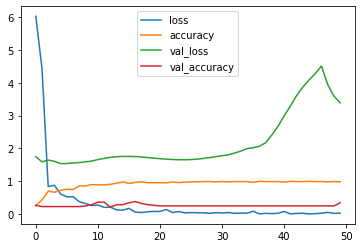

In [16]:
history_df = pd.DataFrame(history.history)
history_df.plot()
plt.show()